In [1]:
# this clones the PGM repository in the ./PGM folder if it does not exists
# please modify this line as needed if you want to have the PMG repository elsewhere
import os, sys
pgm_path = './PGM/'
if not os.path.isdir(out_path): # check if folder exists
    from git import Repo
    Repo.clone_from("https://github.com/jertubiana/PGM.git", pgm_path)
sys.path.append('./PGM/source/')
sys.path.append('./PGM/utilities/')
sys.path.append('./DNA_utils/')

In [2]:
# imports
from common_imports import set_num_threads
set_num_threads(2) # Set the number of cores. Must be executed before importing numpy&numba.
import rbm, RBM_utils, evaluate_learning_utils
import DNA_utils, DNA_sequence_logo, DNA_plots_utils
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import metrics
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline

C:/Users/digioacchino/data_work/repos/PGM/source\numba_utilities.py:1124: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 2d, F), array(float32, 2d, A))
  dmean_v_dw = np.dot(s1.T, V)
C:/Users/digioacchino/data_work/repos/PGM/source\numba_utilities.py:961: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 1d, A), array(float32, 2d, A))
  mean_V = np.dot(weights, V) / sum_weights


In [3]:
# load pre-trained RBM and pre-compute the partition functions
path = './trained_RBMs/'
file_name = 'myrbm-leftright-8th-all_data.data'
RBM_lr_0 = RBM_utils.loadRBM(path + file_name)
RBM_lr_0.AIS(n_betas=40000,verbose=0)

Mismatch dimensions (500, 70), [10, 70], reinitializating I
Mismatch dimensions (500, 20, 4), [10, 20, 4], reinitializating I


(96.84837, 0.008116331395263467)

In [4]:
# load round 8 data
path = './data/'
filename = 's100_8th.fasta'
all_data_8, counts_8 = DNA_utils.load_DNA_MSA(path + filename, drop_duplicates=True, with_counts = True)
n_tot_8 = all_data_8.shape[0]
seq_len_8 = all_data_8.shape[1]
print('Dataset #8 shape =', all_data_8.shape)

# split left and right data
seqs_8_l_2num, counts_8_l = np.unique(all_data_8[:, :20], return_counts=True, axis=0)
all_data_8_l = pd.DataFrame({'sequence' : DNA_utils.num2seq(seqs_8_l_2num),
                             'counts' : counts_8_l})
all_data_8_l['seq2num'] = list(DNA_utils.seq2num(all_data_8_l['sequence'].to_list()))
n_tot_8_l = len(all_data_8_l.sequence)
all_seq_8_l = np.array(all_data_8_l['seq2num'].to_list())
counts_8_l = all_data_8_l['counts'].to_numpy()
print('Dataset #8 shape =', all_data_8_l.shape)

# load round 8 right data 
seqs_8_r_2num, counts_8_r = np.unique(all_data_8[:, 20:], return_counts=True, axis=0)
all_data_8_r = pd.DataFrame({'sequence' : DNA_utils.num2seq(seqs_8_r_2num),
                             'counts' : counts_8_r})
all_data_8_r = all_data_8_r.sort_values(by="counts", ascending=False).reset_index(drop=True)
all_data_8_r['seq2num'] = list(DNA_utils.seq2num(all_data_8_r['sequence'].to_list()))
n_tot_8_r = len(all_data_8_r.sequence)
all_seq_8_r = np.array(all_data_8_r['seq2num'].to_list())
counts_8_r = all_data_8_r['counts'].to_numpy()
print('Dataset #8 shape =', all_data_8_r.shape)
all_data_8_r.sort_values(by="counts", ascending=False)

# put both rounds together
all_data_8_lr = pd.concat([all_data_8_l, all_data_8_r])
all_data_8_lr = all_data_8_lr.reset_index(drop=True)
all_data_8_lr = all_data_8_lr.drop(columns=['seq2num']) # drop this, gives problems with groupby...
all_data_8_lr = all_data_8_lr.groupby(by=["sequence"], as_index=False).sum()
all_data_8_lr = all_data_8_lr.sort_values(by='counts', ascending=False).reset_index(drop=True)
all_seq_8_lr = DNA_utils.seq2num(all_data_8_lr["sequence"].to_list())
counts_8_lr = all_data_8_lr['counts'].to_numpy()

Dataset #8 shape = (719413, 40)
Dataset #8 shape = (196682, 3)
Dataset #8 shape = (253098, 3)


In [5]:
# load experimental data
filename = './data/Aptamer_Exp_Results.csv'
exp_df = pd.read_csv(filename)
exp_rounds = []
for l in exp_df['label']:
    if 'd' in l:
        exp_rounds.append(1)
    elif ('r' in l) and (int(l[1:]) <= 23):
        exp_rounds.append(2)
    elif 'p' in l:
        exp_rounds.append(3)
    else:
        exp_rounds.append(4)
exp_df['experimental_round'] = exp_rounds

In [6]:
# prepare data for plotting - first round
pre_good_binders = exp_df[(exp_df['experimental_round']==1) & (exp_df['binder']=='B')]['sequence'].to_list()
# add ThA, ThB, ThC and ThD to these
pre_good_binders = pre_good_binders + ["AGGGATGATGTGTGGTAGGC","AGGGTAGGTGTGGATGATGC",
                                       "TAGGTTTTGGGTAGGGTGGT","GTAGGATGGGTAGGGTGGTC"]
pre_bad_binders = exp_df[(exp_df['experimental_round']==1) & (exp_df['binder']=='NB')]['sequence'].to_list()
pre_binders_2num = DNA_utils.seq2num(pre_good_binders)
pre_nonbinders_2num = DNA_utils.seq2num(pre_bad_binders)

In [7]:
# add distance information (from full round 8)
expseqs = DNA_utils.seq2num(exp_df["sequence"].to_list())
dists_from_round8 = [min(np.array([np.count_nonzero(x) for x in s != all_seq_8_lr])) for s in expseqs]
exp_df['dist_round8'] = dists_from_round8

In [8]:
# prepare data for plotting - second round
good_binders = exp_df[(exp_df['experimental_round']==2) & (exp_df['binder']=='B')]['sequence'].to_list()
bad_binders = exp_df[(exp_df['experimental_round']==2) & (exp_df['binder']=='NB')]['sequence'].to_list()
good_binders += exp_df[(exp_df['experimental_round']==4) & (exp_df['binder']=='B') & (exp_df['dist_round8']>0)]['sequence'].to_list()
bad_binders += exp_df[(exp_df['experimental_round']==4) & (exp_df['binder']=='NB') & (exp_df['dist_round8']>0)]['sequence'].to_list()
binders_2num = DNA_utils.seq2num(good_binders)
nonbinders_2num = DNA_utils.seq2num(bad_binders)

Threshold position: -20.764274353021698


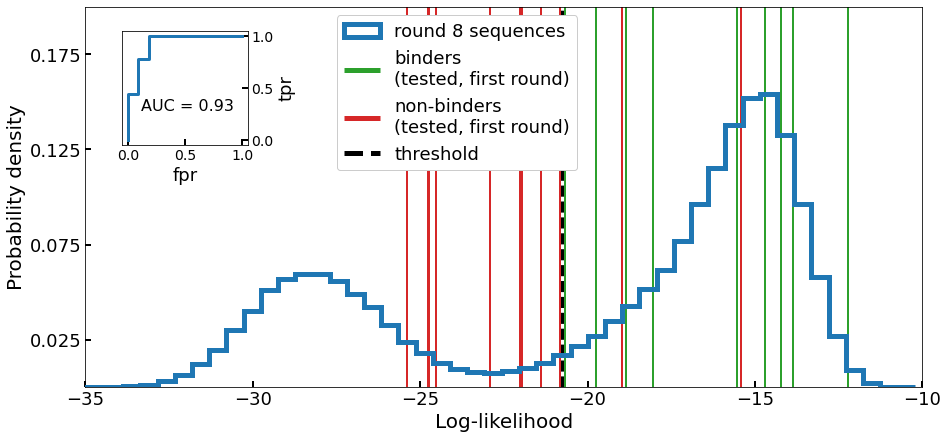

In [9]:
# find threshold and make corresponding figure
fig = plt.figure(figsize=(15,7))
gs = fig.add_gridspec(ncols=1, nrows=1, wspace=0.1, hspace=0.2)
scores_train = RBM_lr_0.likelihood(all_seq_8_lr)
scores_pos = RBM_lr_0.likelihood(pre_binders_2num)
scores_neg = RBM_lr_0.likelihood(pre_nonbinders_2num)

# find threshold
lims = [min(scores_neg), max(scores_pos)]
step = 0.001
curr_thresh = lims[0]
curr_errs = np.sum(scores_pos < curr_thresh) + np.sum(scores_neg > curr_thresh)
min_errs = curr_errs
best_threshs = [curr_thresh]
while curr_thresh < lims[1]:
    curr_thresh += step
    curr_errs = np.sum(scores_pos < curr_thresh) + np.sum(scores_neg > curr_thresh)
    if curr_errs < min_errs:
        best_threshs = [curr_thresh]
        min_errs = curr_errs
    elif curr_errs == min_errs:
        best_threshs.append(curr_thresh)
threshold = np.mean(best_threshs)

# plot
t_ax = fig.add_subplot(gs[0,0])
t_ax.hist(scores_train, density=True, histtype='step', fill=False, bins=50, lw=5, color="C0",
         label="round 8 sequences", zorder=10)
for sp in scores_pos:
    t_ax.vlines(sp, ymin=0, ymax=1, lw=2, color="C2")
for sn in scores_neg:
    t_ax.vlines(sn, ymin=0, ymax=1, lw=2, color="C3")
# threshold
t_ax.vlines(threshold, ymin=0, ymax=1, lw=3, ls='dashed', color="black")    
# only for the legend
t_ax.vlines(0, ymin=0, ymax=1, lw=5, color="C2", label="binders\n(tested, first round)")
t_ax.vlines(0, ymin=0, ymax=1, lw=5, color="C3", label="non-binders\n(tested, first round)")
t_ax.vlines(0, ymin=0, ymax=1, lw=5, ls='dashed', color="black", label="threshold")
t_ax.legend(fontsize=18, loc=(0.3, 0.57), framealpha=1)
t_ax.tick_params(axis='both', direction='in', length=6, width=2, colors='k')
t_ax.tick_params(which='minor', direction='in', length=0, width=2, colors='k')
t_ax.tick_params(axis='both', labelsize=18)
t_ax.set_xlim((-35,-10))
t_ax.set_ylim((0,0.2))
t_ax.set_xlabel("Log-likelihood", fontsize=20)
t_ax.set_ylabel("Probability density", fontsize=20)
t_ax.set_yticks([0.025, 0.075, 0.125, 0.175])
# inset
labels = np.hstack((np.zeros((len(scores_neg))), np.ones((len(scores_pos))))) 
scores = np.hstack((scores_neg, scores_pos))
fpr, tpr, thresholds = metrics.roc_curve(labels, scores)
axins = inset_axes(t_ax, width="100%", height="100%",
                   bbox_to_anchor=(.05, .65, .15, .3),
                   bbox_transform=t_ax.transAxes)
axins.plot(fpr, tpr, lw=3) 
axins.tick_params(axis='both', direction='in', length=6, width=2, colors='k')
axins.tick_params(which='minor', direction='in', length=0, width=2, colors='k')
axins.tick_params(axis='both', labelsize=14)
axins.set_xticks([0,0.5,1])
axins.set_yticks([0,0.5,1])
auc = metrics.auc(fpr, tpr)
axins.text(0.15, 0.3, "AUC = "+str(round(auc,2)), fontsize=16, color='k', transform=axins.transAxes)
axins.set_xlabel("fpr", fontsize=18)
axins.set_ylabel("tpr", fontsize=18)
axins.yaxis.tick_right()
axins.yaxis.set_label_position("right")
#################################################################################################################
print("Threshold position:", threshold)

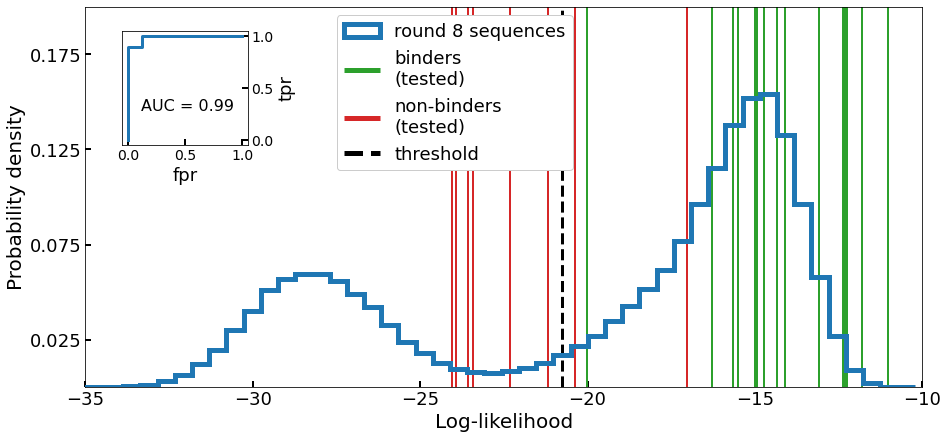

In [10]:
# make figure
fig = plt.figure(figsize=(15,7))
gs = fig.add_gridspec(ncols=1, nrows=1, wspace=0.1, hspace=0.2)
scores_train = RBM_lr_0.likelihood(all_seq_8_lr)
scores_pos = RBM_lr_0.likelihood(binders_2num)
scores_neg = RBM_lr_0.likelihood(nonbinders_2num)
t_ax = fig.add_subplot(gs[0,0])
t_ax.hist(scores_train, density=True, histtype='step', fill=False, bins=50, lw=5, color="C0",
         label="round 8 sequences", zorder=10)
for sp in scores_pos:
    t_ax.vlines(sp, ymin=0, ymax=1, lw=2, color="C2")
for sn in scores_neg:
    t_ax.vlines(sn, ymin=0, ymax=1, lw=2, color="C3")
# threshold
t_ax.vlines(threshold, ymin=0, ymax=1, lw=3, ls='dashed', color="black")
# only for the legend
t_ax.vlines(0, ymin=0, ymax=1, lw=5, color="C2", label="binders\n(tested)")
t_ax.vlines(0, ymin=0, ymax=1, lw=5, color="C3", label="non-binders\n(tested)")
t_ax.vlines(0, ymin=0, ymax=1, lw=5, ls='dashed', color="black", label="threshold")
t_ax.legend(fontsize=18, loc=(0.3, 0.57), framealpha=1)
t_ax.tick_params(axis='both', direction='in', length=6, width=2, colors='k')
t_ax.tick_params(which='minor', direction='in', length=0, width=2, colors='k')
t_ax.tick_params(axis='both', labelsize=18)
t_ax.set_xlim((-35,-10))
t_ax.set_ylim((0, 0.2))
t_ax.set_xlabel("Log-likelihood", fontsize=20)
t_ax.set_ylabel("Probability density", fontsize=20)
t_ax.set_yticks([0.025, 0.075, 0.125, 0.175])
# inset
labels = np.hstack((np.zeros((len(scores_neg))), np.ones((len(scores_pos))))) 
scores = np.hstack((scores_neg, scores_pos))
fpr, tpr, thresholds = metrics.roc_curve(labels, scores)
axins = inset_axes(t_ax, width="100%", height="100%",
                   bbox_to_anchor=(.05, .65, .15, .3),
                   bbox_transform=t_ax.transAxes)
axins.plot(fpr, tpr, lw=3) 
axins.tick_params(axis='both', direction='in', length=6, width=2, colors='k')
axins.tick_params(which='minor', direction='in', length=0, width=2, colors='k')
axins.tick_params(axis='both', labelsize=14)
axins.set_xticks([0,0.5,1])
axins.set_yticks([0,0.5,1])
auc = metrics.auc(fpr, tpr)
axins.text(0.15, 0.3, "AUC = "+str(round(auc,2)), fontsize=16, color='k', transform=axins.transAxes)
axins.set_xlabel("fpr", fontsize=18)
axins.set_ylabel("tpr", fontsize=18)
axins.yaxis.tick_right()
axins.yaxis.set_label_position("right")

In [11]:
# Print tabel with loglikelihoods and prediction (comparison with the established threshold)
exp_df['loglik'] = RBM_lr_0.likelihood(DNA_utils.seq2num(exp_df['sequence'].to_list()))
exp_df['binder_prediction'] = exp_df['loglik'] > threshold
exp_df

,label,sequence,binder,binding site,experimental_round,dist_round8,loglik,binder_prediction
0,r1,AGTGATGATGTGTGGTAGGC,NB,NaN,2,0,-23.438995,False
1,r2,AGTGTAGGTGTGGATGATGC,NB,NaN,2,0,-24.045723,False
2,r3,TAGGTTTTGGGTAGCGTGGT,NB,NaN,2,1,-22.308464,False
3,r4,AGGGATGATGTGTGGCAGGA,NB,NaN,2,1,-23.574989,False
4,r5,CTAGGACGGGTAGGGCGGTG,NB,NaN,2,1,-21.180527,False
5,r6,AGGGATGTGTGTGGTAGGCT,NB,NaN,2,0,-23.943520,False
6,r7,AGGGATGCTGCGTGGTAGGC,B,AB,2,0,-20.030602,True
7,r8,GAGGGTTGGTGTGGTTGGCA,B,CD,2,0,-11.023964,True
8,r9,AGGGTTGGTGTGTGGTTGGC,B,CD,2,0,-11.796181,True
9,r10,ATGGTTGGTTTATGGTTGGC,B,CD,2,1,-14.740990,True
